<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/08_solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ケーススタディ： solubility data

Max Kuhn and Kjell Johnson. Applied Predictive Modeling. Springer, 2013. に出てくるデータセット (Section 6.1)

http://appliedpredictivemodeling.com/data

* 説明変数は下記の228個
 * Two hundred and eight binary “fingerprints” that indicate the presence or absence of a particular chemical substructure.
 * Sixteen count descriptors, such as the number of bonds or the number of bromine atoms.
 * Four continuous descriptors, such as molecular weight or surface area.

* 目的変数はlog solubility
 * 範囲は−11.6 to 1.6、平均は−2.7

### 1) 訓練データとテストデータを読む

In [1]:
import numpy as np
import pandas as pd

In [2]:
X_train = pd.read_csv('solTrainX.csv')
y_train = pd.read_csv('solTrainY.csv')['x']

X_test = pd.read_csv('solTestX.csv')
y_test = pd.read_csv('solTestY.csv')['x']

### 2) 連続値をとる20変数の様子をみる

* seabornで散布図を描く。
* もちろん訓練データを使う。
* 縦軸は目的変数とする。

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# 連続値をとる変数の名前を取り出す

continuous = [s for s in X_train.columns.to_list()
  if s[:3] == 'Num' or s[:3] == 'Hyd' or s[:3] == 'Mol' or s[:3] == 'Sur']
print(len(continuous), continuous)

20 ['MolWeight', 'NumAtoms', 'NumNonHAtoms', 'NumBonds', 'NumNonHBonds', 'NumMultBonds', 'NumRotBonds', 'NumDblBonds', 'NumAromaticBonds', 'NumHydrogen', 'NumCarbon', 'NumNitrogen', 'NumOxygen', 'NumSulfer', 'NumChlorine', 'NumHalogen', 'NumRings', 'HydrophilicFactor', 'SurfaceArea1', 'SurfaceArea2']


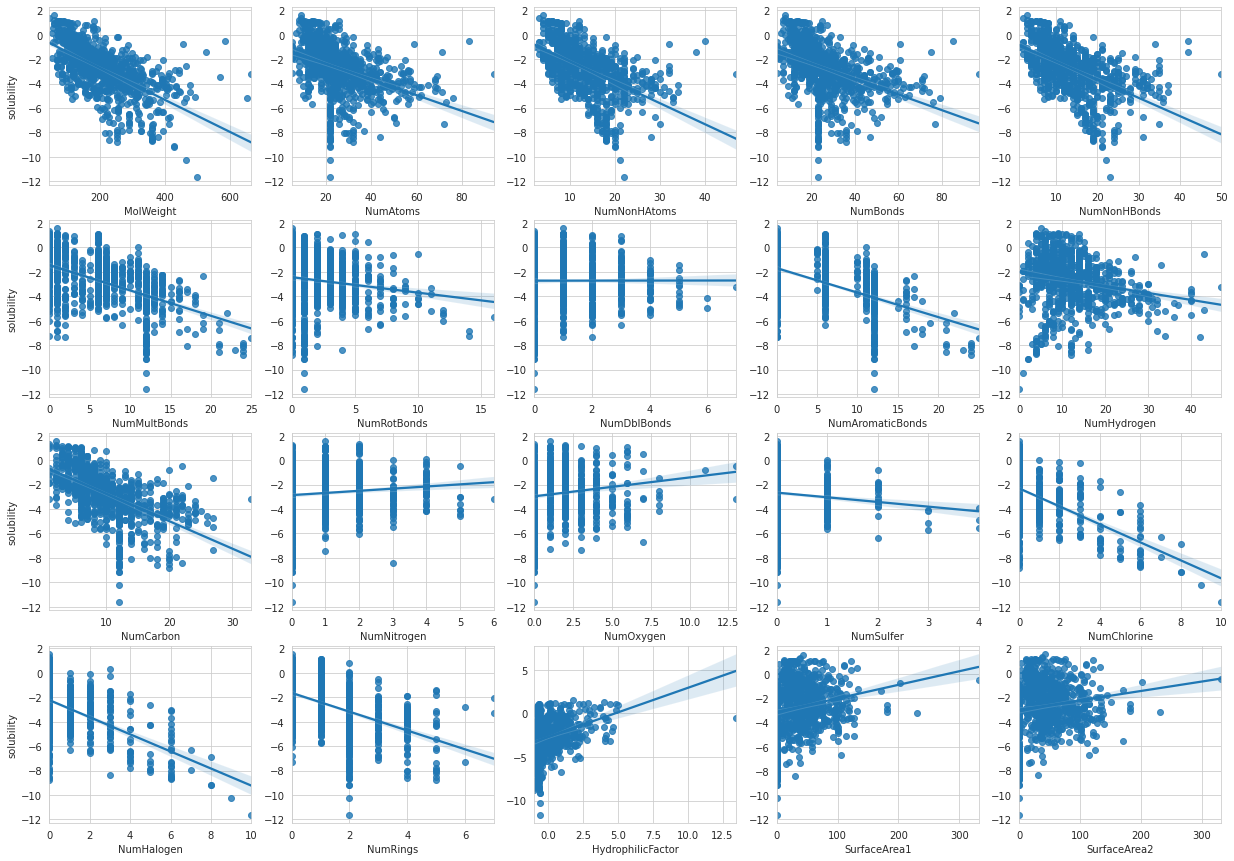

In [5]:
X_train['solubility'] = y_train # 図を描くために、一時的にこうしておく

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21.0, 15.0))
for i in range(20):
  ax = fig.add_subplot(4, 5, i+1)
  sns.regplot(x=continuous[i], y='solubility', data=X_train, ax=ax)
  if i % 5 != 0: ax.set_ylabel('')

X_train = X_train.drop('solubility', axis=1) # 図を描き終えたので、元に戻す

### 3) ２値変数の部分の雰囲気を見る

In [6]:
binary = X_train.columns[X_train.columns.str.startswith('FP')].to_list()
print(len(binary))
X_train[binary].describe()

208


,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,FP011,FP012,FP013,FP014,FP015,FP016,FP017,FP018,FP019,FP020,FP021,FP022,FP023,FP024,FP025,FP026,FP027,FP028,FP029,FP030,FP031,FP032,FP033,FP034,FP035,FP036,FP037,FP038,FP039,FP040,...,FP169,FP170,FP171,FP172,FP173,FP174,FP175,FP176,FP177,FP178,FP179,FP180,FP181,FP182,FP183,FP184,FP185,FP186,FP187,FP188,FP189,FP190,FP191,FP192,FP193,FP194,FP195,FP196,FP197,FP198,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,...,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,0.493165,0.539432,0.436383,0.584648,0.579390,0.400631,0.363828,0.325973,0.279706,0.178759,0.214511,0.176656,0.166141,0.160883,0.860147,0.146162,0.144059,0.131441,0.121977,0.119874,0.120925,0.104101,0.123028,0.112513,0.115668,0.084122,0.097792,0.106204,0.101998,0.093586,0.089380,0.073607,0.069401,0.079916,0.072555,0.075710,0.070452,0.086225,0.074658,0.068349,...,0.186120,0.184017,0.169295,0.151420,0.141956,0.130389,0.134595,0.121977,0.120925,0.120925,0.097792,0.107256,0.093586,0.098843,0.075710,0.084122,0.085174,0.076761,0.072555,0.068349,0.076761,0.072555,0.070452,0.060988,0.062040,0.058885,0.060988,0.056782,0.052576,0.056782,0.047319,0.049422,0.052576,0.257624,0.114616,0.098843,0.077813,0.059937,0.056782,0.112513
std,0.500216,0.498705,0.496197,0.493042,0.493917,0.490284,0.481353,0.468984,0.449091,0.383352,0.410699,0.381578,0.372403,0.367617,0.347017,0.353454,0.351334,0.338059,0.327431,0.324985,0.326212,0.305552,0.328643,0.316163,0.319994,0.277717,0.297189,0.308261,0.302805,0.291405,0.285441,0.261267,0.254268,0.271306,0.259541,0.264672,0.256042,0.280844,0.262977,0.252477,...,0.389408,0.387702,0.375210,0.358646,0.349188,0.336908,0.341470,0.327431,0.326212,0.326212,0.297189,0.309601,0.291405,0.298609,0.264672,0.277717,0.279287,0.266352,0.259541,0.252477,0.266352,0.259541,0.256042,0.239435,0.241355,0.235534,0.239435,0.231548,0.223303,0.231548,0.212431,0.216861,0.223303,0.437556,0.318726,0.298609,0.268018,0.237495,0.231548,0.316163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### 4) 2値の部分と連続値の部分をあわせた元のデータに、単純に線形回帰を適用

In [7]:
from sklearn.linear_model import LinearRegression

X_train = pd.concat([X_train[binary], X_train[continuous]], axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
# テストデータでの予測を評価する
from sklearn.metrics import mean_squared_error

X_test = pd.concat([X_test[binary], X_test[continuous]], axis=1)
y_test_pred = reg.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

RMSE: 0.7968957706086087


---

（ここから試行錯誤してみてください。）

---

### 5) PCAを使って2値の部分だけ次元を落としてみる

In [9]:
from sklearn.decomposition import PCA

n_components = 100 # 使用する主成分の個数
pca = PCA(n_components=n_components)
pca.fit(X_train[binary])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

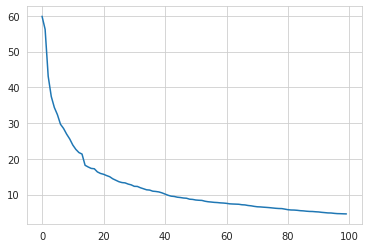

In [10]:
plt.plot(range(n_components), pca.singular_values_)

In [11]:
X_train_binary = X_train[binary]
X_train_binary_embedded = pca.transform(X_train_binary)

In [12]:
# 最初のレコードの次元削減バージョンを見てみる

X_train_binary_embedded[0]

array([ 1.45333496e+00, -1.44179928e+00, -1.07689363e+00,  1.49383011e+00,
        1.09059605e+00, -1.20846160e+00, -9.72704133e-01, -5.81835177e-02,
        1.08131037e-02,  1.50577480e+00, -9.01356613e-01, -9.33780867e-01,
        1.07081845e-01, -7.78480724e-01, -1.29601770e+00,  3.10016017e-01,
        6.58408265e-03,  2.40796045e-01,  1.51684703e-01,  1.01514775e-01,
        6.17768326e-01,  3.85365152e-01, -2.00713269e-01,  5.81726787e-01,
        2.46260195e-01, -3.30513437e-01,  2.55350093e-01,  3.00813270e-01,
       -6.33164232e-01,  8.89408668e-02,  3.52133157e-01,  2.05029892e-01,
        2.07763933e-01,  3.22645829e-01,  2.82150380e-01, -2.28477673e-01,
       -1.14500272e-01, -1.96933424e-01,  1.84357666e-01,  1.10955616e-01,
        1.84982641e-01,  3.54925223e-01, -1.49752852e-01,  7.61711328e-01,
        3.95698562e-02,  2.15349180e-01, -3.50235658e-01,  2.13243685e-02,
       -8.31430848e-02, -2.01684085e-01, -6.95707901e-02,  3.38028390e-01,
        2.61029932e-01, -

In [13]:
# 次元削減した後の部分と元の連続値の部分をくっつける

X_train_embedded = np.concatenate([X_train_binary_embedded, X_train[continuous]], 1)

In [14]:
# X_train_embeddedを使って回帰係数の推定をしてみてください。
#　そしてテストデータでの予測スコアを求めてみてください。
# （もちろん、テストデータの2値の部分も次元削減する必要があります。）

reg = LinearRegression()
# ........

### 6) ２値変数のインタラクションを考慮してみる

* その上で主成分分析を使う

In [15]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly.fit(X_train_binary)

PolynomialFeatures(degree=2, include_bias=False, interaction_only=True,
                   order='C')

In [16]:
X_train_binary_poly = poly.transform(X_train_binary)

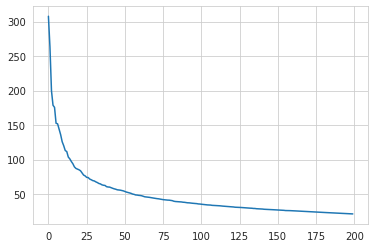

In [17]:
n_components = 200
pca = PCA(n_components=n_components)
pca.fit(X_train_binary_poly)
plt.plot(range(n_components), pca.singular_values_)

# 課題8
* solubilityデータセットのテストデータに対して、できるだけ予測性能の良いモデルを見つけよう
 * Ridge回帰やLassoを使ってもいいです。
 * 特徴量はどのように加工してもいいです。（上では2値変数にPCAを使った）
